In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score, f1_score,accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC ,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

import numpy as np

<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">2º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº 49718</li>
        <li>Bruno Antunes, Aluno Nº 49755</li>
    </ul>
</div>

# 1 - Introdução




# 2 - Desenvolvimento


## 2.1 - Transformação de dados com TF-IDF

limpeza dos textos (HTML, regex, min_df, etc.),

seleção de parâmetros do TfidfVectorizer (ex.: min_df, max_df, ngram_range, token_pattern, stop_words, norm, etc.),

evitar vocabulários demasiado grandes (afetam desempenho e overfitting).


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pickle
from nltk.stem import  LancasterStemmer, PorterStemmer

# carregar dados
D = pickle.load(open("imdbFull.p", "rb"))
data = D["data"]
labels = D["target"]

data = data[0:5000] # TODO: Remove this when pickling the final data
labels = labels[0:5000]

def clean_text(t):
    t = t.replace("<br />", " ")                  
    t = re.sub(r"[^a-zA-Z]+", " ", t)             
    t = t.lower()
    return t

def apply_stemming(text, stemmer):
    return " ".join(stemmer.stem(word) for word in text.split())

def clean_dataset(data, stemmer):
    X_clean = []
    
    for t in data:
        cleaned = clean_text(t)
        cleaned = apply_stemming(cleaned, stemmer)
        X_clean.append(cleaned)
    
    return X_clean



In [ ]:
# transformar em 0 e 1
y_bin = np.where(labels < 5, 0, 1)

# dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    data, y_bin, test_size=0.25, random_state=42, stratify=y_bin
)

lancaster = LancasterStemmer()
porter = PorterStemmer()

lr = LogisticRegression(max_iter=2000, random_state=42)
svm = LinearSVC(random_state=42)

# parâmetros TF-IDF a testar
min_dfs = [1, 3, 5]
max_features = [1000, 5000]
stop_words_list = [None, "english"]
token_patterns = [r"[a-zA-Z]{2,}", r"[a-zA-Z]{3,}"]
ngrams = [(1,1), (1,2)]
classifiers = [lr, svm]
stemmers = [lancaster, porter]

results = []

def run_combination(X_train, X_test, stemmer, min_df,  sw, tp,ng,max_feature):
    print("Combo: ", stemmer, min_df,  sw, tp,ng,max_feature)
    X_train_clean = clean_dataset(X_train, stemmer) 
    X_test_clean = clean_dataset(X_test, stemmer)
    
    # criar TF-IDF para esta combinação
    vectorizer = TfidfVectorizer(
        min_df=min_df,
        stop_words=sw,
        token_pattern=tp,
        ngram_range=ng,
        max_features=max_feature,
    )
    metrics = []
    
    # aplicar TF-IDF
    Xtr = vectorizer.fit_transform(X_train_clean)
    Xts = vectorizer.transform(X_test_clean)
    
    for classifier in classifiers:
        classifier.fit(Xtr, y_train)
        pred_lr = classifier.predict(Xts)
        metrics.append(accuracy_score(y_test, pred_lr))
    
    media = np.sum(metrics) / 2
    media_geo = np.sqrt(np.prod(metrics)) # maioritariamente parecida com a outra
    
    print(f"Stemmer={stemmer} | MEDIA={media} | MEDIA GEO={media_geo}") # ordenar por performance da SVM
    return vectorizer, stemmer, media, media_geo

"""
# Sequencialmente
for stemmer in stemmers:
    for max_feature in max_features:
        for min_df in min_dfs:
            for sw in stop_words_list:
                for tp in token_patterns:
                    for ng in ngrams:
                        run_combination(X_train, X_test, stemmer, min_df, sw, tp, ng, max_feature)
"""

def parallel_tfidf(data, use_pickled=False):
    fname = "data_clean.pkl"
    
    if(use_pickled):
        vectorizer, cleaned_data = pickle.load(open(fname, 'rb'))
        return vectorizer, cleaned_data, 

    total = len(min_dfs) * len(max_features) * len(stop_words_list) * len(token_patterns) * len(ngrams) * len(stemmers) * len(classifiers)
    print(f"Combinações: {total}")


    # Paralelo
    all_combinations = [
        (X_train, X_test,stemmer,min_df,sw,tp,ng,max_feature)
        for stemmer in stemmers
        for min_df in min_dfs
        for sw in stop_words_list
        for tp in token_patterns
        for ng in ngrams
        for max_feature in max_features
    ]
    
    # 2.4 minutos (96 * 2 combos)
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(run_combination)(*combo) for combo in all_combinations
    )

    sorted_results = sorted(results, key=lambda x: x[3], reverse=True)
    
    vectorizer, stemmer, media, media_geo = sorted_results[0]
    cleaned_data = clean_dataset(data, stemmer)
    
    print("Final Combo", stemmer, vectorizer)
    
    file = open(fname, 'wb')
    pickle.dump((vectorizer,cleaned_data), file)
    return vectorizer, cleaned_data

vectorizer, cleaned_data = parallel_tfidf(data, use_pickled=True)
print(cleaned_data[0][:1000])
print(vectorizer)


zero day lead you to think even re think whi two boy young men would do what they did commit mutual suicid via slaughter their classmat it captur what must be beyond a bizarr mode of be for two human who have decid to withdraw from common civil in order to defin their own mutual world via coupl destruct it is not a perfect movi but given what money time the filmmak and actor had it is a remark product in term of explain the motiv and action of the two young suicid murder it is better than eleph in term of be a film that get under our rationalist skin it is a far far better film than almost anyth you are like to see flaw but honest with a terribl honesti
TfidfVectorizer(max_features=5000, min_df=5, ngram_range=(1, 2),
                token_pattern='[a-zA-Z]{2,}')


In [20]:
X_transformed = vectorizer.fit_transform(cleaned_data) # This SHOULD be pickled

## 2.2 - Treino de Classificadores 
- train/test split com estratificação,
- k-fold cross validation, StratifiedKFold,

- análise de métricas: matriz de confusão, recall, precision.



In [ ]:
# regressor linear com test train split e idf
# exemplo feito durante a aula só para referencia para a malta. Usar o vectorizer de cima
"""
X_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)

# transform train e test
X_train_idf = vectorizer.transform(X_train)
X_test_idf = vectorizer.transform(X_test)

# regressor linear
lr = LogisticRegression(max_iter=1000)

# fit
lr.fit(X_train_idf, y_train)

# predict
lr.predict(X_test_idf)
"""

'\nX_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)\n\n# fit no train\nidf = TfidfVectorizer(min_df=5).fit(X_train)\n\n# transform train e test\nX_train_idf = idf.transform(X_train)\nX_test_idf = idf.transform(X_test)\n\n# regressor linear\nlr = LogisticRegression(max_iter=1000)\n\n# fit\nlr.fit(X_train_idf, y_train)\n\n# predict\nlr.predict(X_test_idf)\n'

### 2.2.1 - Classificação multi-classe

Treinar um modelo que recebe o texto da crítica e prevê a pontuação exata (1–4 ou 7–10 → total de 8 classes).
- Escolhes um ou mais modelos adequados (com base nos slides):
- Exemplos de classificadores
- Logistic Regression,
- SVM,
- Linear Regression,
- Lasso Regression

Depois:
-  comparar classificadores e regressões,
- converter previsões da regressão em classes,
- analisar qual abordagem funciona melhor.

### 2.2.2 - Análise com Regressão Linear

Treinar um modelo para prever a pontuação contínua da crítica. Depois, converter as previsões contínuas do regressor para rótulos de classificação:

valores preditos → mapeados para 1–4 e 7–10.


### 2.2.3 - Análise dos resultados

- desempenho da classificação direta,
- desempenho da classificação derivada da regressão.
Para regressão, medir:
- MAE
- MSE

## 2.3 - Clustering

1. Aplicar K-Means como método base de clustering.
2. Aplicar um segundo método (AgglomerativeClustering) para comparação.
3. Avaliar e comparar os métodos considerando:
    - separação dos clusters (silhouette)
    - distância entre centróides
    - palavras representativas
    - consistência visual (PCA)
    - distribuição dos clusters
4. Investigar o impacto da variação de k no desempenho e interpretação dos clusters.
5. Escolher o método e valor de k mais adequado com base nas métricas.


In [23]:
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram


def top_words_per_cluster(centers, feature_names, n=15):
    for i, c in enumerate(centers):
        print(f"\nCluster {i}:")
        idx = np.argsort(c)[::-1][:n]
        print(", ".join(feature_names[j] for j in idx))


def show_examples_per_cluster(data, labels, n=3):
    for c in np.unique(labels):
        print(f"\n===== Cluster {c} =====")
        idx = np.where(labels == c)[0][:n]
        for i in idx:
            print(data[i][:300], "\n---")

# 
def plot_clusters(X, labels, title="Clusters"):
    pca = PCA(n_components=3)
    X_3d = pca.fit_transform(X)
    #centers_3d = pca.transform(centers)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
        c=labels, s=3
    )

    #ax.scatter(
    #    centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2],
    #    c="red", s=300, marker="X", edgecolors="black"
    #)

    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    plt.show()

# Retirado do https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


k = 5

### 2.3.1 - Clustering com KMeans

KMeans (k=5)
Inertia: 4779.846946526064
Silhouette Score: 0.001708660721413046


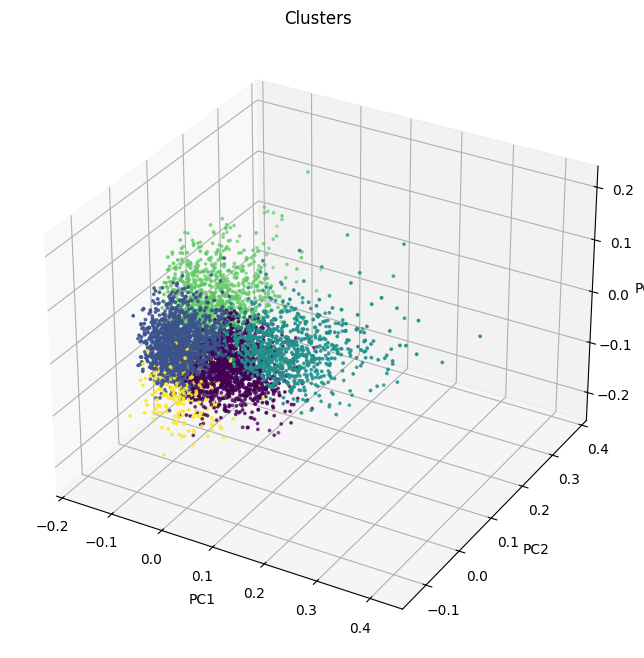

In [17]:
from sklearn.cluster import KMeans
import numpy as np

# número de clusters a testar (ex.: 5)
k = 5 # TODO: Testar vários K

def kmeans_cluster(k, X):
    print(f"KMeans (k={k})")

    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=5,
        max_iter=1000,
        random_state=42
    )

    kmeans.fit(X)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    inertia = kmeans.inertia_
    sil = None
    
    if k > 1:
        sil = silhouette_score(X, labels)

    print("Inertia:", inertia)
    print("Silhouette Score:", sil)

    return labels, centers, inertia, sil

labels_km,centers_km,inertia_km,sil_km = kmeans_cluster(k,X_transformed)


plot_clusters(X_transformed, labels_km)

### 2.3.2 - Clustering com AgglomerativeClustering

AgglomerativeClustering (k=5)
Silhouette Score: 0.0012523173835531155


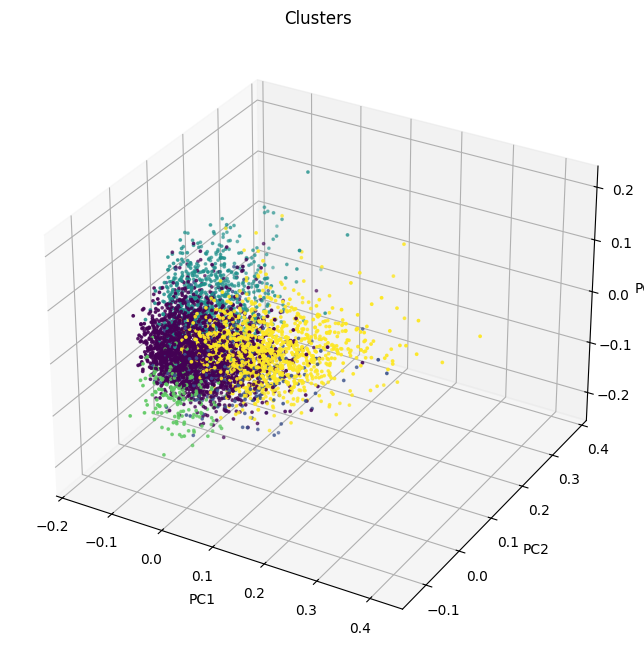

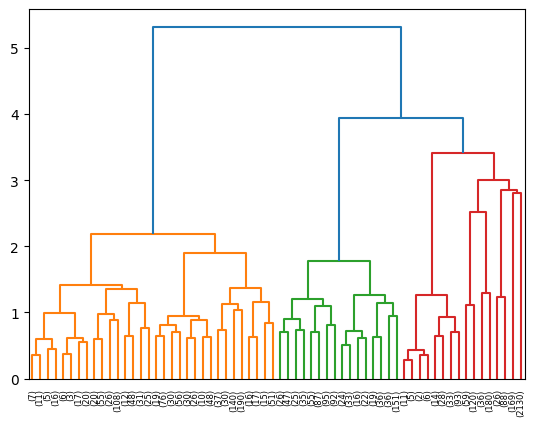

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA


def agg_cluster(k, X):
    print(f"AgglomerativeClustering (k={k})")
    
    X_dense = X_transformed.toarray()
    X_pca = PCA(n_components=20).fit_transform(X_dense)
    

    agg = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward",
        compute_distances=True # para os dendogramas,
    )

    labels = agg.fit_predict(X_pca)  # hierárquico precisa array
    sil = None
    if(k>1):
        sil = silhouette_score(X, labels)
        print("Silhouette Score:", sil)


    # Calcular centro de cada cluster
    centers = []
    for c in range(k):
        idx = np.where(labels == c)[0]
        centers.append(X[idx].mean(axis=0))

    centers = np.array(centers).squeeze()

    return agg, labels, centers, sil


# TODO: Cuidado que aumentar isto é dose
agg, labels_agg,centers_agg,sil_agg = agg_cluster(k,X_transformed)
plot_clusters(X_transformed, labels_agg)

plot_dendrogram(agg, truncate_mode="level", p=5)

### 2.3.3 - Comparação de clusters e impacto do parametro K

In [16]:
import collections
print(collections.Counter(labels))

"""
# Palavvras dos clusters (cortado aos 400)
for i in range(k):
    print(f"\nCluster {i} exemplo:\n")
    idx = np.where(labels == i)[0][:3]
    for j in idx:
        print(data[j][:400], "\n---")
"""

def compare_methods(sil_kmeans, sil_hier):
    print("\n### Comparação entre métodos ###\n")
    print("Silhouette K-Means:", sil_kmeans)
    print("Silhouette Hierárquico:", sil_hier)

    if sil_kmeans > sil_hier:
        print("\n K-Means apresenta melhor separação de clusters.")
    else:
        print("\nClustering Hierárquico apresenta melhor separação de clusters.")


compare_methods(sil_km, sil_agg)

Counter({np.int32(1): 1455, np.int32(0): 1385, np.int32(3): 1134, np.int32(2): 810, np.int32(4): 216})

### Comparação entre métodos ###

Silhouette K-Means: 0.001708660721413046
Silhouette Hierárquico: -0.001650602953685775

 K-Means apresenta melhor separação de clusters.


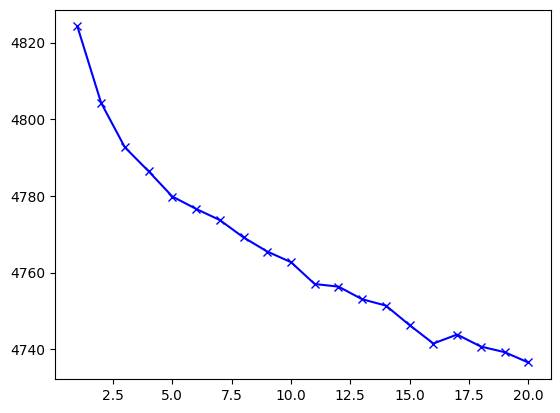

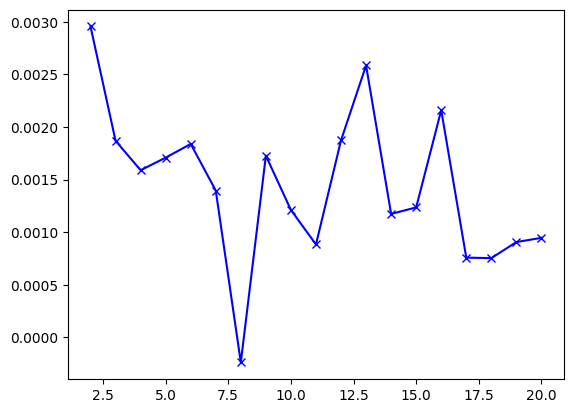

In [ ]:
def evaluate_k_values(X, k_list):
    sil_scores = []
    inertia_scores = []
    print(k_list)
    
    for k in k_list:
        labels, centers, inertia, sil = kmeans_cluster(k,X)
        sil_scores.append(sil)
        inertia_scores.append(inertia)

    return sil_scores, inertia_scores

k_list = range(1,20+1)


sil_scores, inertia_scores = evaluate_k_values(X_transformed,k_list)

plt.plot(k_list, inertia_scores, 'bx-')
plt.show()

plt.plot(k_list, sil_scores, 'bx-')
plt.show()

# 3 - Conclusões

# 4 - Bibliografia

- https://www.reddit.com/r/statistics/comments/180nm8y/question_pca_for_visualizing_clusters/
- https://pca4ds.github.io/pca-and-clustering.html
- https://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook
- https://www.kaggle.com/code/sabanasimbutt/clustering-visualization-of-clusters-using-pca
- https://www.kaggle.com/code/hasanaltunay/agglomerative-clustering-dendrograms-pca
- https://projectai.in/projects/ac30fffa-f885-440c-a9a4-54228fdfebc9/tasks/22ec2a03-6e13-43be-9f45-889382db2d78?tab=task
- https://apxml.com/courses/nlp-fundamentals/chapter-3-nlp-text-classification/hyperparameter-tuning-text-models
